In [1]:
!pip install -U contextualized_topic_models

     |████████████████████████████████| 24.2MB 1.4MB/s 
     |████████████████████████████████| 14.5MB 192kB/s 
     |████████████████████████████████| 235kB 44.9MB/s 
     |████████████████████████████████| 71kB 8.3MB/s 
     |████████████████████████████████| 778kB 43.7MB/s 
     |████████████████████████████████| 1.1MB 45.0MB/s 
     |████████████████████████████████| 890kB 38.2MB/s 
     |████████████████████████████████| 3.0MB 33.4MB/s 
  Created wheel for sentence-transformers: filename=sentence_transformers-0.3.5.1-cp36-none-any.whl size=100387 sha256=6536cd13c549e892228747980a68382601a13d07963b3b58439c2d82ed84fd7a
  Stored in directory: /root/.cache/pip/wheels/1a/05/25/5201c408b8048c9663d75c82dc079cb72633cf543af1aa84da
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp36-none-any.whl size=893257 sha256=309f5a2e558b25f6132ee037802cc63aa1e3b96e8ad3629dc76b62c479072757
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e5

In [2]:
!pip install pyLDAvis

     |████████████████████████████████| 1.6MB 3.4MB/s 
  Created wheel for pyLDAvis: filename=pyLDAvis-2.1.2-py2.py3-none-any.whl size=97711 sha256=02dc16f17aa07d0f7b3c0756d3d8505ca9790c8249774dd0b98dbb99118f3532
  Stored in directory: /root/.cache/pip/wheels/98/71/24/513a99e58bb6b8465bae4d2d5e9dba8f0bef8179e3051ac414
Successfully built pyLDAvis


# Importing Packages

In [3]:
import numpy as np
import pandas as pd
import warnings
import nltk
import re
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer, SnowballStemmer
from nltk.corpus import wordnet
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from gensim.models import TfidfModel
from sklearn.metrics import pairwise_distances
# spacy for lemmatization
import spacy
from pprint import pprint
# Gensim
import gensim
import gensim.corpora as corpora
from gensim.corpora import Dictionary
import gensim.downloader as api
from gensim.corpora import Dictionary
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
nltk.download('stopwords')
# Plotting tools
import pyLDAvis
import pyLDAvis.gensim  # don't skip this
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.model_selection import GridSearchCV

from contextualized_topic_models.models.ctm import CTM
from contextualized_topic_models.utils.data_preparation import TextHandler
from contextualized_topic_models.utils.data_preparation import bert_embeddings_from_file
from contextualized_topic_models.datasets.dataset import CTMDataset
from contextualized_topic_models.utils.preprocessing import SimplePreprocessing
from contextualized_topic_models.evaluation.measures import TopicDiversity, CoherenceNPMI, CoherenceWordEmbeddings, InvertedRBO

from sklearn.decomposition import NMF, LatentDirichletAllocation
%matplotlib inline
warnings.filterwarnings('ignore')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [58]:
import itertools

In [86]:
import torch

In [26]:
from gensim.models import Word2Vec

# Utils

In [27]:
# Compute coherence score for word embeddings
class CoherenceWordEmbeddings1():
    def __init__(self, topics, word2vec_path=None, binary=False):
        self.topics = topics
        self.binary = binary
        if word2vec_path is None:
            print('Please specify word2vec bin file path')
        else:
            self.wv = gensim.models.KeyedVectors.load_word2vec_format(word2vec_path)

    def score(self, topk=10, binary= False):
        if topk > len(self.topics[0]):
            raise Exception('Words in topics are less than topk')
        else:
            arrays = []
            for index, topic in enumerate(self.topics):
                if len(topic) > 0:
                    local_simi = []
                    for word1, word2 in itertools.combinations(topic[0:topk], 2):
                        if word1 in self.wv.vocab and word2 in self.wv.vocab:
                            local_simi.append(self.wv.similarity(word1, word2))
                    arrays.append(np.mean(local_simi))
            return np.mean(arrays)


In [93]:
# Get topic words with values of each word
def topic_lists(best_components, n, in_size, k=10):
        assert k <= in_size, "k must be <= input size."
        component_dists = best_components
        topics = []
        val = []
        for i in range(n):
            x, idxs = torch.topk(component_dists[i], k)
            component_words = [training_dataset.idx2token[idx]
                               for idx in idxs.cpu().numpy()]
            topics.append(component_words)
            val.append(x.tolist())
        return topics, val

In [64]:
from wordcloud import WordCloud, STOPWORDS 
import matplotlib.pyplot as plt

# Get wordcloud to a topic cluster
def get_wordcloud(topic): 
  topic_words = ''     
  for word in topic: 
    topic_words += word + " "
    
  print(topic_words)
  wordcloud = WordCloud(width = 400, height = 400, 
                  background_color ='white',
                  min_font_size = 10).generate(topic_words) 
      
  # plot the WordCloud image                        
  plt.figure(figsize = (4, 4), facecolor = None) 
  plt.imshow(wordcloud) 
  plt.axis("off") 
  plt.tight_layout(pad = 0) 
    
  plt.show() 

# Dataset Preprocessing


In [4]:
df = pd.read_csv('/content/drive/My Drive/capstone project/data.csv')

In [5]:
df = df[df["Prodcut ID"]== "AVphgVaX1cnluZ0-DR74"]

In [6]:
data = df["Review"].values.tolist()

In [7]:
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use', "also", "tablet", "dont", "cool", "awful", "beautiful", "basic", "great", "nice", "awesome", "good", "bad", "amazing", "excellent", "simple",
                      "love", "hate", "enjoy", "recommend", "amazon"])

In [8]:
def text_cleaning(texts):
    processed_texts = []

    for s in texts:
        # normalization 1: xxxThis is a --> xxx. This is a (missing delimiter)
        s = re.sub(r'([a-z])([A-Z])', r'\1\. \2', s)  # before lower case
        # normalization 2: lower case
        s = s.lower()
        # normalization 3: "&gt", "&lt"
        s = re.sub(r'&gt|&lt', ' ', s)
        # normalization 4: letter repetition (if more than 2)
        s = re.sub(r'([a-z])\1{2,}', r'\1', s)
        # normalization 5: non-word repetition (if more than 1)
        s = re.sub(r'([\W+])\1{1,}', r'\1', s)
        # normalization 6: string * as delimiter
        s = re.sub(r'\*|\W\*|\*\W', '. ', s)
        # normalization 7: stuff in parenthesis, assumed to be less informal
        s = re.sub(r'\(.*?\)', '. ', s)
        # normalization 8: xxx[?!]. -- > xxx.
        s = re.sub(r'\W+?\.', '.', s)
        # normalization 9: [.?!] --> [.?!] xxx
        s = re.sub(r'(\.|\?|!)(\w)', r'\1 \2', s)
        # normalization 10: ' ing ', noise text
        s = re.sub(r' ing ', ' ', s)
        # normalization 11: noise text
        s = re.sub(r'product received for free[.| ]', ' ', s)
        # normalization 12: phrase repetition
        s = re.sub(r'(.{2,}?)\1{1,}', r'\1', s)

        processed_texts.append(s.strip())
    
    return processed_texts

In [9]:
# Remove Emails
data = [re.sub('\S*@\S*\s?', '', sent) for sent in data]

# Remove new line characters
data = [re.sub('\s+', ' ', sent) for sent in data]

# Remove distracting single quotes
data = [re.sub("\'", "", sent) for sent in data]

data[0]

'Good basic tablet for checking email , web browsing , and reading ebooks.'

In [10]:
data = text_cleaning(data)

In [11]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

data_words = list(sent_to_words(data))

data_words[0]

['good',
 'basic',
 'tablet',
 'for',
 'checking',
 'email',
 'web',
 'browsing',
 'and',
 'reading',
 'ebooks']

In [12]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

# See trigram example
print(trigram_mod[bigram_mod[data_words[0]]])

['good', 'basic', 'tablet', 'for', 'checking_email', 'web', 'browsing', 'and', 'reading', 'ebooks']


In [13]:
# Define functions for stopwords, bigrams, trigrams and lemmatization
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatize_stemming(sent_list, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    return [[SnowballStemmer("english").stem(word.lemma_) for word in nlp(" ".join(sent)) if word.pos_ in allowed_postags] for sent in sent_list] #keeping only desired part of speech

In [77]:
# Remove Stop Words
data_words_nostops = remove_stopwords(data_words)

# Form Bigrams
data_words_bigrams = make_bigrams(data_words_nostops)

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
# python3 -m spacy download en
nlp = spacy.load('en', disable=['parser', 'ner'])

In [ ]:
strings = [" ".join(text) for text in data_words_bigrams]

In [ ]:
for i in range(len(strings)):
  f = open("rv1.txt", "a")
  if strings[i]:
    f.write(strings[i] + '\n')

## Contextualized Topic Model Using BERT

### Default n_components with Reduction

In [68]:
handler = TextHandler("rv1.txt")
handler.prepare() # create vocabulary and training data

In [19]:
# generate BERT data
training_bert = bert_embeddings_from_file("rv1.txt", "bert-base-nli-mean-tokens")

100%|██████████| 405M/405M [00:51<00:00, 7.87MB/s]


In [20]:
training_dataset = CTMDataset(handler.bow, training_bert, handler.idx2token)

In [71]:
ctm_50_reduce = CTM(input_size=len(handler.vocab), bert_input_size=768, inference_type="combined", n_components=50, reduce_on_plateau=True)

In [72]:
ctm_50_reduce.fit(training_dataset)

Settings: 
                   N Components: 50
                   Topic Prior Mean: 0.0
                   Topic Prior Variance: 0.98
                   Model Type: prodLDA
                   Hidden Sizes: (100, 100)
                   Activation: softplus
                   Dropout: 0.2
                   Learn Priors: True
                   Learning Rate: 0.002
                   Momentum: 0.99
                   Reduce On Plateau: True
                   Save Dir: None
Epoch: [1/100]	Samples: [10955/1095500]	Train Loss: 128.55935230194189	Time: 0:00:31.156634
Epoch: [2/100]	Samples: [21910/1095500]	Train Loss: 117.90327921753766	Time: 0:00:30.311107
Epoch: [3/100]	Samples: [32865/1095500]	Train Loss: 114.95040016331014	Time: 0:00:30.076596
Epoch: [4/100]	Samples: [43820/1095500]	Train Loss: 113.34990609890247	Time: 0:00:29.998473
Epoch: [5/100]	Samples: [54775/1095500]	Train Loss: 112.37797274361023	Time: 0:00:29.715995
Epoch: [6/100]	Samples: [65730/1095500]	Train Loss: 111.750093

In [73]:
ctm_50_reduce.save('/content/')

In [74]:
td = TopicDiversity(ctm_50_reduce.get_topic_lists(25))
td.score(topk=25)

0.4752

In [75]:
ctm_50_reduce.get_topic_lists(10)

[['pay',
  'cheap',
  'money',
  'ads',
  'slow',
  'cant',
  'gets',
  'job_done',
  'little',
  'ok'],
 ['fast',
  'battery_life',
  'memory',
  'storage',
  'camera',
  'picture',
  'long',
  'card',
  'battery',
  'processor'],
 ['desktop',
  'works',
  'done',
  'job',
  'purposes',
  'working',
  'fan',
  'okay',
  'sometimes',
  'pop'],
 ['games',
  'old',
  'year',
  'loves',
  'bought',
  'play',
  'son',
  'able',
  'watch',
  'perfect'],
 ['books',
  'read',
  'reading',
  'book',
  'go',
  'online',
  'local_library',
  'reader',
  'carry',
  'check'],
 ['clear',
  'clarity',
  'user_friendly',
  'picture',
  'pictures',
  'fast',
  'graphics',
  'color',
  'colors',
  'affordable'],
 ['get',
  'really',
  'would',
  'got',
  'watching',
  'movies',
  'cant',
  'little',
  'could',
  'one'],
 ['tablets',
  'price',
  'play',
  'screen',
  'device',
  'store',
  'android',
  'app',
  'apps',
  'fire'],
 ['easy',
  'navigate',
  'setup',
  'operate',
  'set',
  'handle',
  'l

In [79]:
sentences = []
for i in range(len(data_words_bigrams)):
  if data_words_bigrams[i]:
    sentences.append(data_words_bigrams[i])

In [80]:
# train model
model = Word2Vec(sentences)
# summarize the loaded model
print(model)
# summarize vocabulary
words = list(model.wv.vocab)
print(words)
# access vector for one word
print(model['book'])
# save model
model.wv.save_word2vec_format('reviews_word2vec.bin')
#model.save('model.bin')
# load model
new_model = gensim.models.KeyedVectors.load_word2vec_format('reviews_word2vec.bin')
print(new_model)

Word2Vec(vocab=2120, size=100, alpha=0.025)
['checking_email', 'web', 'browsing', 'reading', 'ebooks', 'buy', 'would', 'strongly', 'buying', 'reader', 'surfing', 'brought', 'old', 'local', 'store', 'said', 'need', 'replace', 'suggested', 'much', 'one', 'easy', 'set', 'plus', 'price', 'reasonable', 'inexpensive', 'someone', 'often', 'got', 'niece', 'say', 'product', 'sturdy', 'enough', 'kids', 'older', 'able', 'play', 'games', 'watch', 'videos', 'occasionally', 'read', 'overall', 'wont', 'break', 'bank', 'learning', 'apps', 'app', 'purchased', 'toddler', 'best', 'investment', 'yet', 'added', 'protection', 'plan', 'happy', 'purchase', 'serves', 'purpose', 'device', 'thought', 'could', 'phone', 'applications', 'limited', 'comes', 'video', 'outside', 'amazons', 'us', 'overly', 'complicated', 'screen', 'right', 'size', 'eyes', 'perfect', 'things', 'last', 'long', 'time', 'son', 'birthday', 'hasnt', 'opened', 'brother', 'law', 'works', 'case', 'two', 'young', 'everything', 'ask', 'limit', 'v

In [81]:
word2vec_path = '/content/reviews_word2vec.bin'
we_coh = CoherenceWordEmbeddings1(word2vec_path=word2vec_path, topics=ctm_50_reduce.get_topic_lists(25))
we_coh.score(topk=25)

0.9164115

In [91]:
# Get model parameters
best_components_50_re = ctm_50_reduce.best_components # best weights
n_50_re = ctm_50_reduce.n_components
in_size = ctm_50_reduce.input_size

In [94]:
len(topic_lists(best_components_50_re, n_50_re, in_size, 25)[0])

50

In [95]:
topic_lists(best_components_50_re, n_50_re, in_size, 25)

([['pay',
   'cheap',
   'money',
   'ads',
   'slow',
   'cant',
   'gets',
   'job_done',
   'little',
   'ok',
   'cost',
   'annoying',
   'bucks',
   'complain',
   'paid',
   'less',
   'pretty',
   'worth',
   'isnt',
   'lock',
   'pad',
   'go_wrong',
   'bank',
   'removed',
   'kinda'],
  ['fast',
   'battery_life',
   'memory',
   'storage',
   'camera',
   'picture',
   'long',
   'card',
   'battery',
   'processor',
   'gb',
   'clear',
   'quality',
   'expandable',
   'hd',
   'micro_sd',
   'speed',
   'resolution',
   'pictures',
   'video',
   'lasts',
   'quick',
   'color',
   'slot',
   'response'],
  ['desktop',
   'works',
   'done',
   'job',
   'purposes',
   'working',
   'fan',
   'okay',
   'sometimes',
   'pop',
   'advertising',
   'start',
   'system',
   'port',
   'advertisements',
   'electronics',
   'adds',
   'shock',
   'connected',
   'needing',
   'freezing',
   'general',
   'advertised',
   'confusing',
   'meet'],
  ['games',
   'old',
   'y

pay cheap money ads slow cant gets job_done little ok cost annoying bucks complain paid less pretty worth isnt lock pad go_wrong bank removed kinda break specs ad cannot expensive cant_beat rough expect deal guess paying didnt doesnt remove job advertisements get buck lags works confusing points okay overall ipad thats spent extra bang spend subsidized hard bit yes wont runs tho warning kind nothing drop meaning times shouldnt processor downfall ones budget bloatware certainly glitch super stuff samsung waste tab bb decent rid occasionally worry let holding crashes meant feel millennium falcon say counts functionality dollars actually feet touchscreen dirt painful low cause really sub though laggy havent advertising regret obviously fine irked anymore solid reason getting bf approx reward thick stand care sign cracking toss youre arent lag worst wouldnt idea otherwise mess secured wasnt charging_port believe pass well freezes stress turn spots tabby subscribing dollar ask feels price o

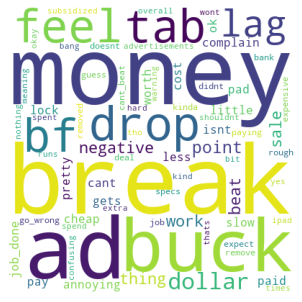

fast battery_life memory storage camera picture long card battery processor gb clear quality expandable hd micro_sd speed resolution pictures video lasts quick color slot response via increase sd_card expand built expandable_memory quad_core high expansion graphics display vid responsive upgrade mini added add wonderful screen decent sound capacity takes unit superb internal sd equal external loads front application owner wifi bright additional operating cards power usb models ability quad expanded faster lightweight expanding earlier photos seems image touchscreen helps allows fills ok capability crisp idea durable bonus fantastic rear_cameras stalled lasting colors output performance sensitive adorable windows pros speaker micro wi_fi holds_charge internal_memory volume poor vibrant processing_speed lots cons low connection real clarity decling issue overall features quickly crystal_clear gbs adapter whose inch starts connected audio processors nook task stylish port bargain charges 

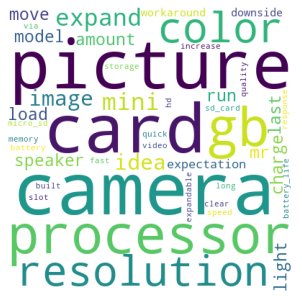

desktop works done job purposes working fan okay sometimes pop advertising start system port advertisements electronics adds shock connected needing freezing general advertised confusing meet basics instructions power sucks reboot order prime_member chromecast base sign necessary sends freeze damaging kodi connecting ads mails hoping hang otherwise intention accidentally purpose including moment fee hair major complains icons flawlessly ran whats must hide worrying ok speech minor negative skin gadget enhanced info omg generally suggest suppose problems typing soon freed automation spot mobile felt forth entertainment write terrible dislike cell_phone packed songs keeping loading instagram crowd appointments microphone ebook lagging tho recognizing intense powering location completing train explained downfall placed contact hesitated basically shown startup forty rid filled serves appearing included completed surprise freezes stand kind slick spending hot numerous peaceful upon savers 

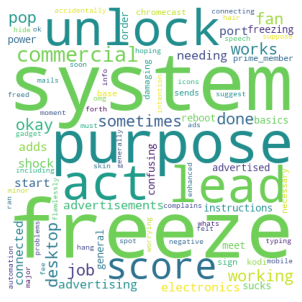

games old year loves bought play son able watch perfect books purchased read yr videos parental_controls download movies likes uses daughter netflix well size free music easy grandson set present nephew enough importantly mom niece playing plays gift christmas mother navigate apps time web little access inexpensive cant_beat absolutely watches fun homework solitaire enjoys birthday reading surf price plenty take even downloaded kid color small black_friday pictures hes lot parental law granddaughter years got reads lots loved watching favorite learning durable picture grand easily friendly prime child pleased grandchildren affordable family anything super one account video listen buy purse educational browse five item school ipdad carries especiall wars ten downloading gan works brilliant raised product age boy ages givinem saund wanted clear neef ppl fire right two mothers_day icons internet pretty three sumsung fore learing satisfly could competable boundaries memory fulfills deliver

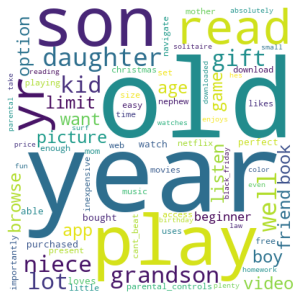

books read reading book go online local_library reader carry check anywhere take class wherever able email library deck purse lighting around easier messenger many magazines carrying light audio place emails paper night download kindle facebook larger makes phone travel fits computer traveling clutter mostly access reads onto area plus uses hold holds newspapers pocket authors sun lots public size internet without using allows convenient ebooks situations blue_shade like quickly wanted lot coffee europe eyes borrowed breeze physical small easy accounts bed fiance lightweight net fire college keep cell_phone textbook selections asleep outside mail within_minutes ebook house unlimited readers easily checking want print nicely orders except adjustable laid bag sample weight browse form perfect likes laptop cruise flimsier digital material always lamp load drinking lake articles comfortably news hard enlarge vacation school etc web way map cozy wife every paperback selection something long

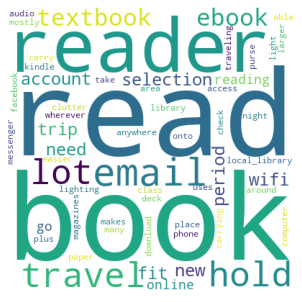

clear clarity user_friendly picture pictures fast graphics color colors affordable efficient versatile vibrant advanced entry brightness camera lightweight inexpensive clean response light_weight ease covers bright multi sounds compact responsive sharp appreciate sony build poor latest switched toshiba weight con portable pro image users playback loads holds_charge high crystal_clear processing_speed portability front quality handheld quick darn entry_level somewhat dads durable protected displays vid resolution chip speed pin completed soft useful visual phenomenal effect average sells scratches protective hesitated insignia surprisingly cluttered result prob purple prime_membership customizable slick noted ouch pleasantly_surprised search_engine handy accessible eventually abc technologically taken wonderful unnecessary code language thomas housework matured blocked omg eat convenient section inches mi deeply married appropriate cracks toilet entirely durability youve wondering slipp

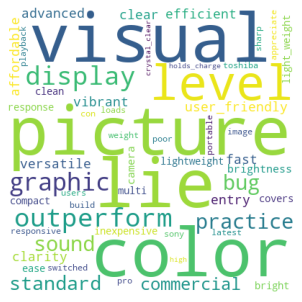

get really would got watching movies cant little could one worth didnt even time like ads buy games watch im still quality bought screen wanted need work price pay something slow never old getting cheap want year money much expect play kids apps another picture disable assumed perfect new well take happy tablets sometimes netflix breaks first pretty black_friday going unable everything better stuck works playing anyway put enough videos point lot purchased son reading lose register pixels see around battery app notice bucks pad shows call maybe et gal christmas slowly branch xbox unobtrusive internet two served books tv wee people sure sd_card best device thing terrible problems right free registered music phone steal go password brand noticed least back unlock doesnt approved already download young speaking know using store tube long barely microsd read bothered fifteen havent wouldnt television home give able freak looking battery_life purchase must saying ive razor since rember thou

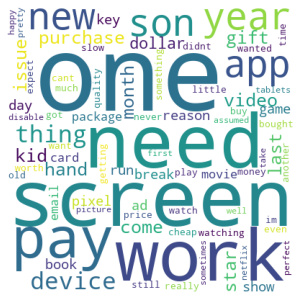

tablets price play screen device store android app apps fire google would bare_bones quality get test one even value os available coupon works better best low overly still purchased much buy source resolution discarded reports traditional defects googles obtained seek dots dark pays many ecosystem fine new performance battery_life bluetooth really like amazons well force ips looking pad ways manager since state reliable swipe access cheap receipt etc going need compromise first rock simpler based toward several small find right work far dead_pixels little spots want kindle user seen another bought hd considerably buying geared rooting using worth around anyone packaging everything point account expect vehicle though easy youre games cant_beat size pretty could thing conclusion install noticed fee uses tvs apple read folder netflix root whether overall time sale cnn focus register today music may modifications money fast ok someone books black_friday ever used make free angle old lot re

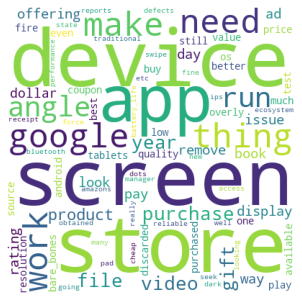

easy navigate setup operate set handle light_weight quick understand compact carry light handy convenient friendly ease lightweight navigation clear anyone selection easily bright transfer technology fun interface accessible portable fairly learn tech inexpensive user travel parents economical age medium visible easiest connects holds_charge durable kindell hold preloaded parental_controls intially immediately load eyes comfortable vacationing reliable within_minutes blurring programs threw user_friendly bag right savvy traveling granny mothers arthritis people flip grandkids pleasure citizen casual graphics literacy airport onlots gor favorites plane wide covers combined instructions tangerine consumers techy onto straightforward hospital knowing incredibly sturdy pick background transport keyboard unboxing relative elegant gateway cobtrols nurse senior imagined provides options inlaws link beach purse worm resources elderly grab fios sketchy drawn ebay gives notifying hooking smooth 

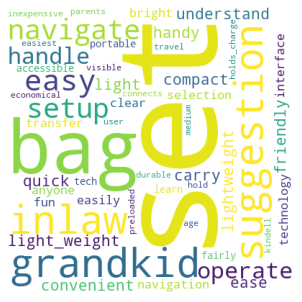

friends anyone purchase product friend pleased customer satisfied customer_service recommended happy item equipment would products always sales staff ever helpful best buy shop knowledgeable choice glad bestbuy thank looking helped experience thanks expected service items delivery exactly checked others definitely walked family purchasing future door impressed electronic everyone totally person shopping ti verses joy promised thrilled finding support attention patient decision demonstrated purchases recomend highly_recommended pricing company employees told refer rep guided contacts benefits stores yes place adore stated giving family_members reliable prizes team trail particular encourage possibilities brand market business viewed continue interested hope geek seasin prices appreciate com whole considered winner favorite hisitating shower found persons terrific prize initially dearly contest brst rugged suggest todays hoped near coz whim client chris outstanding availabilty record sel

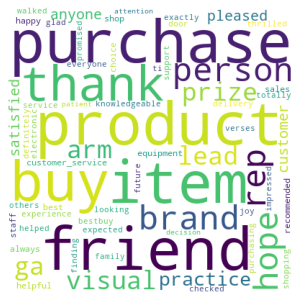

kids time set free download children able school tablets kid child apps profile educational access learning account parental_controls many keep limit control two even games childrens work like help different memory make lot without add sites separately card limits parental_control wish stuff learn freetime put parent give profiles charge ages parents lots way allows fun durable play long well could required entertained bought young using storage family get tool always christmas easily program app want features got timers curfew adults getting purchased anything cant wifi usage certain purchases inappropriate busy downloading stay password three playing easy user overall tons ability something game options used quickly daughter enough books spend specific students away programs videos activity skills hold product downloaded spending son childs year available locks amount keeps doesnt break internet seem old accessing us gb money day hours defeats every needs go grand case choose never s

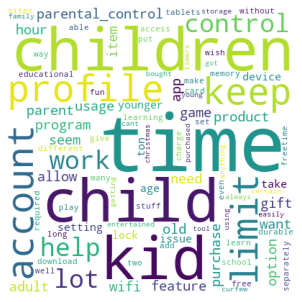

purchased fire kindle husband one bought wife mother new much christmas books uses first gift happy granddaughter read daughter loves another loved pleased enjoyed using birthday two older really law liked games always sale grandson features son grand years went replace came email decided second years_ago sister reading likes dad mom buy kindlefire playing original wanted reader grandsons friend absolutely internet enjoying play got web since version present saw set gave surf thanking would purchase tooth family navigate hes gifts online time grandchildren old movies netflix fathers_day music reads check im able used plays easy book newer actual hd thrilled asked niece couple actually nephew kindles us item solitaire device operate best tablets every generation camera updated fiance ps watch year several shes gen fact ever bed updates friends perfect like daughters surprised user_friendly listening enjoys told need technology lady favorite ipdad owned watching showed gan already fires 

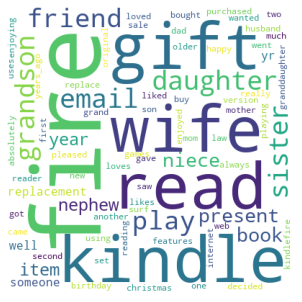

games playing plays play son uses videos favorite music learning likes enjoys reads grandson loves mostly read able granddaughter educational daughter facebook grand grandkids watches education boy talk books game watch listen download yr tube brother nephew everyhing enjoyed reading mom letting lots xmas listening husband aunt bought hasnt surf school ny year pld abd watching played old stream purchased recipe got perfect mybe everyday minecraft whoe downloads expert downloading casino checks browse niece puzzles complaints daily etc online bough age solely teenage mother yo homework grandmother clue birthday sister movies communicate wants law gan closely carries shes hours al films fun usefulness thaks province hes convient communicating lot buisness boundaries behaved upto de enhanse neef stack especiall xpectations onand ipdad parens trading brilliant raised fathers riverbank ling checking competable continent moves entretaiment interests ppl minut uploaded representation learing 

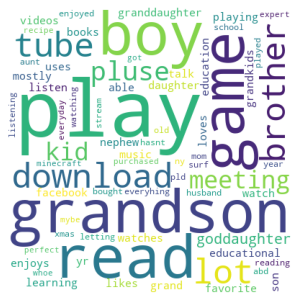

one kindle still better fire much charge two tablets first since get years new long last charger ive longer pad really battery cheaper purchased charging screen charging_port replacement would bought replace loose children another hdx well didnt quality version time original defective cord price lasted happy deal little however back battery_life works even cant_beat im issues could far working hd getting plug definitely bit kindles months years_ago ports child purchase buy later fine like faster damaged older going happened using upgrade wont buying lot second decided work things month product used charged sure kids grown couple problem got wife updates broke year day pretty fires dropped old lasts week cant theyre died made think previous something want keep model worth though within right wanted return fixed best cheap properly unit put warranty tear power toddler low doesnt money continue lighter fall disappointed thinking liked owned showing exchange port refund son case generation

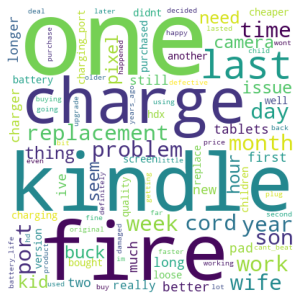

buy best one first would get got exchanged back purchase gave advised said policy could used return time christmas purchased refund never day defective second worked warranty another item bought product black_friday nothing contacted refused didnt ever store two see went happy call help even wouldnt took sale fix week tried right problem im ordered months told charge couldnt think fine wanted work opened new ive go issues factory weeks need wife month finally reset gift screen pay shooting online thought geek_squad someone buying sure person rush make made anyone mother sales february turn shopping due bottom thing replacement keep turned cracked say deal issue exchange called put stock explained kindles going since credit_card early unable glitching sticker inspect defected rep trouble disappointed star several customer attempts works take ended initially home broken found son anything customer_service connect know later decided steps sold late friend unfortunately well happened husba

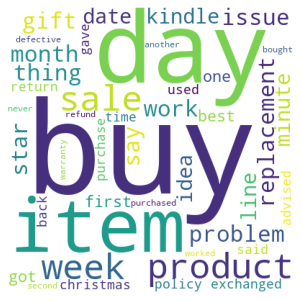

black_friday cant_beat deal sale go_wrong bucks couldnt money thanksgiving buck every_penny worth complain bang cant weekend super paid picked fifty steal resist beat deals happier dollars raffle ever couldnt_pass caught per spent ask nothing winner heck samsung best pass regular ir friday job_done cannot got moneys dollar prize buying essentials believe regret spend dreamed glad tag name_brand girl alone gets walmart bookstore shouldve normally hurry special poker value price win youll buy everybody decision wont thought fastest beaten discounted anything compares impulse hassles outrageous beats pulled bf five lowest neice dime tabs dinner chance bank toss youtubing market buys fanciest outdid avoid drop storm bery onblack cheap decide wasnt bestbuy anywhere readers forcing double lil exceptional break gret dare sell mobile til stock teens cheaply planning prices purchsed thaler id mor touches unions pick comparable unreal promotional tuff couldve complants handed smile cheapest supp

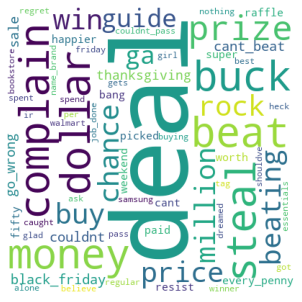

web surfing internet browsing online facebook reading email surf check etc social_media browse emails mails mail ebooks mostly news discover book exciting searching reader checking_email mainly net including serves capture emailing checking meets catch books search memorable moments purpose downloading twitter lite articles social tasks utube chat rear_cameras comparison access entertainment read library lots occasional bills streaming ect stories thei storing purposes usage listening everyday digital public magazines readers basics comics websites barnes carefree handles opportunity resume breeze searches shopping series activity keeping newspaper general front msgs items underground calander rental listen ereader offers payments differents hotels face airfare communications favorite outlets catalogs nobles playing sync using thos audio networking utilizing sun ineternet barebones cars allow ya game instructibles media reservations purchashed record snapping tweaks cell_phone convenie

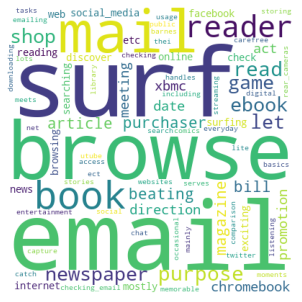

movies watch small perfect something need everything wanted travel enough carry little read size purse computer internet go music phone books email traveling take right inexpensive reading buy want im watching tv light big looking ease plane makes portable listen videos book anywhere wonder fit prime lot movie around much really well screen color download news netflix convenient easy wonderful price shop cant_beat could web get bigger online emails finger needs happy check shopping trip smaller best shows browse easily card bill thing expensive affordable comics perfectly heavy deal surf even reservations sitting smart definitely reader games dimensions hd techie think might fits able worth bucks money light_weight streaming throw compact tips car travelling value subway consequently pretty quality piece supplement loves memory absolutely bag pleased powrful play fast go_wrong bed moms purchase television laptops incredible anything enjoying clear wi_fi mom larger library anyone laptop

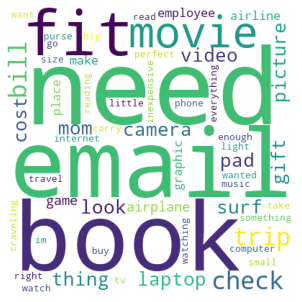

low price cheap quality pad decent little better worth overall performance expensive money cost screen point well value resolution pretty camera paid less inexpensive slow display cant_beat isnt picture speed though much poor bargain looking pay sharp sufficient touch hd works still ok impressive tabs table compared fine range high_end definitely contrast makes fantastic youre lot feeling budget pros bit solid processor cons sound response fast cant plastic high expect speaker quite image slower market annoying touchscreen speedy functions get entry_level bucks battery_life tablets cheaper media_consumption weak build yes ipad powerful okay hard go_wrong enough fraction reader beat lags lower video especially rca tag wonderful arent ads given top worthwhile expectations graphics feel obviously tab want really hesitate models fairly offers consumption cameras functional mini priced things kind samsung responsive compare pad_air volume dollar consideration speakers signal dull prime_memb

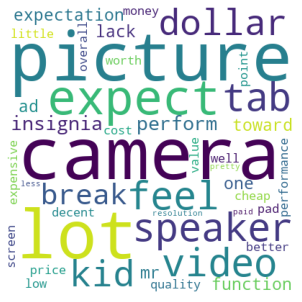

fire screen books kindle reading download like read easy purchased mac tablets well default light size apps ignore little prime one would free get im brightness price standby current app quality feature movies drag speech storage cost small first music library synched watch much nook many old dimmer new enough set adjustments buy worthwhile things washington weather value time find overdrive post need book however bought go something online blue bit color web hd able access since sound reader around background pad browsing best accessories advertising battery_life used paper_white sitting tap take traffic watching say shorter videos meander someplace perfect camn mistakes using oil allowances commerce ingrained dared notion sixed joined intrigued realm starbucks idiot pdf adapting video doesnt bothers black memory tv features years text fun picture makes low still stores device five lot button resolution crisp trial means card update transferring bright know better compact cheap write 

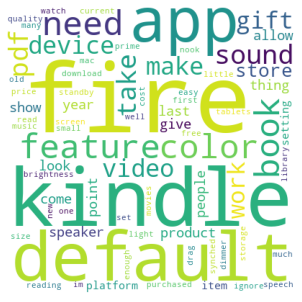

kids adults children young kid busy younger keep adult school parental_control breaking proof keeps learning option ages teens beginners monitor occupied parents child daily parent students teenagers entertained road_trip tables control break hours prefect fun stay homework limit safe daycare worry charged case programs quiet entertain starter boys mode limits childs durable users educational parental grabbed destroyed everyone pre usage bank restrictions math necessarily tons anybody sharing toddler middle friendly together gaming table timeframe road_trips tine entertaing timers stable arguing futures eliminate crack resource recommendable digitizer protective_case activities recommending profile win timer die mad profiles tricky playtime cook versatile cringe backup wants teacher center car_rides distract parental_controls mexico program skills existing toys stephanie stickers fat occupy girls tots tablets car expense smashed cute arguments typically lol start guard thier long unlim

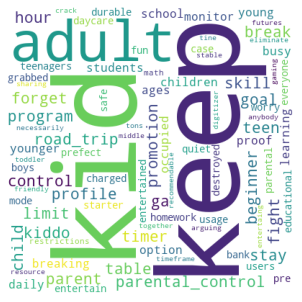

videos web music watch netflix video surf isnt decent slow streaming little internet screen apps well movies bit surfing works app prime browsing job_done looking fastest email watching gets anything youtube ads spotify like store pretty cant reading google resolution need fine want cheap really limited access games browser listen get weak play etc device facebook something much online bigger tv however check quality support emails camera better crunchyroll pad reader price lot pay delete low inexpensive net fast hard cast shows say expect playing keyboard stream doesnt things home ok smoothly small wanted micro_sd used annoying find flixter magazine sluggish anticipating swype amazons chosen requirement im show gaming would browse social_media smartphone fan enough tie choice worth appstore notes mostly functions complain download work pages tube purpose connection listening bothered android firefox commute though function sale chromecast hulu articles thing bluetooth cant_beat ask bi

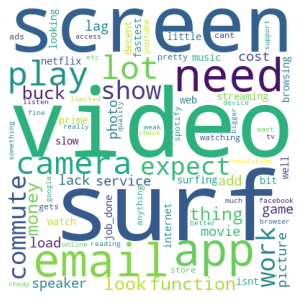

first another second last one two never back years problems ive broke every quit nd ended stolen third stopped_working returning turn months replaced broken working become hopefully lasted went havent longer water several got mine worked th charge took stopped come died twice weeks replacement long sent decided returned gave warranty within turned wore finally week later replace thanked turning bd fourth ever getting return already taking start defective time couple came wake saw kindles wouldnt purchasing owned chance buying newest cleared disappointed brand lost launcher since might shut problem restart ownership dead_pixels forever month days green hazard dies charging originally collecting anothers returened blet sleep going brought slipped hasnt refund boyfriend given far hooked plugged oldest started wanted haywire continuous literally froze end frozen lines onrs day nova manufacture requested lose didnt numerous probls single diss get tried gotten visit wait sooner completely re

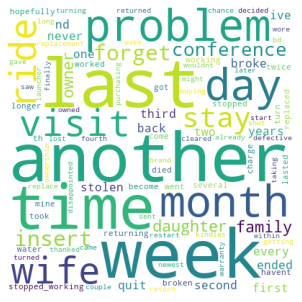

exactly everything fraction skeptical basics expected brands practically needs bells whistles need reasonable advertised minimum food nothing_fancy fragile completed functional listed price exceed fully sophisticated customizable gadget hesitated rate vacuum renew accomplished ouch forty thomas reference cluttered peaceful incredible pin telling performs especially testing table fortune heavily functionality unnecessary mi toilet junk placed department ea switching hence words result continued code talked steal slipped onboard cash must noted pressed accidental nightly eat fyi recall specifications un struggle complaing abc mention googleplay polaroid faulty megapixels eyesight renewal enable wow housework lime lead casting believed vs exact replaceable troubleshooting afordable cruzing advert filters blocked storming digi mins inserts musical land challenging unicorn beetle tomorrow copies frames requirement louder atleast matured strain ghosting cancel expectations defender plague da

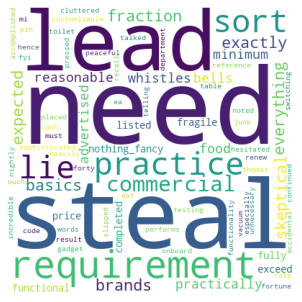

kindle fire new upgrade older version replace original better fires replacement newer previous hd improved second upgraded model years_ago features pleased explore rear_facing camera happy previously lighter cheaper much several kindles expandable_memory benefits updated wrote registering third family replaced thinner reader reviewed sleek faster replaces satisfied improvements front color generation chose earlier wife easier inch blessing definitely versions slimmer years grateful eighth paper_white bite backlit quite ease nook bells whistles extremely wifes difference expected paperwhite user_friendly heavier monochromatic requirements hds addition contrast reasonable owned familiar similar functions gradually aidiobooks cameras sleeping camcorder impaired exclusive life absolutely plus increased added affordable designs sealed scientific galaxy successor conscience benefit portability organized fingertips match many finctional excellentlty addable accessability models caliber hardes

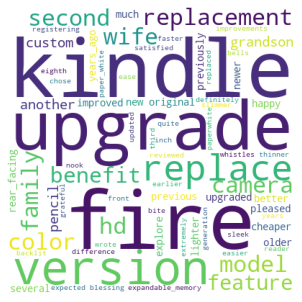

kids bought tablets one child two get christmas happy would purchased set buy kid well time able son children purchase year price want got best old since money games much product little young didnt lot need play everything easy like really gift work gifts cheap family cant thing item sons loved ages definitely pad could worth free still device giving three highly parental_controls even quality fire screen im black_friday deal put go mom apps right daughter version perfect nephew nephews first watch especially things access getting sure years navigate loves kindle user_friendly overall buying memory playing wish always case purchases thought spend initially looking works made niece apple break give absolutely younger movies download something setting couldnt sale uses present yr warranty better mother pleased make seem wife four another control hed ok features long enough ready asked last never used phone far grandchildren take using app decent choose issues way account anything anyone 

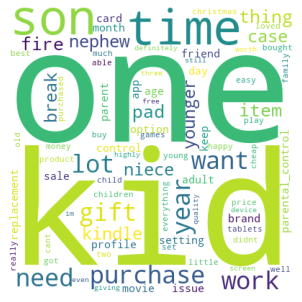

parental_controls friendly setup child easy educational easily operate user_friendly parental_control set beginners navigate learn parent students adults fun learning profiles ages kid young school durable users parental beginner restrictions controls parents adult user profile resources options teens material children ease programs account update pick blocks features accounts handle monitor create age_appropriate ereader applications manage help access age quick selection middle setting lots control kids alike classroom technology safety downloading childrens stephanie away resource feature fairly sites kinds choose protection security skills skill useful separate preloaded con limits allows required website shouldnt share controlled activities settings process unwanted ixl starter membership signed instructor mode provides moving safe light_weight offering tons teach ways understand sets usage preteen limit option content elementary different entertainment st versatile make ability d

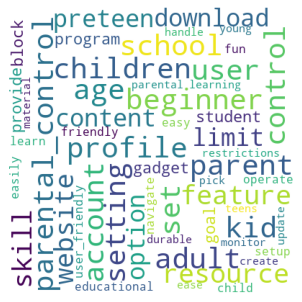

christmas gifts gift gave enjoyed present presents loved grandkids bought liked grandchildren nephews two birthday made excited nieces everyone got cousin family_member santa someone put holiday person received purchased know thanksgiving receive family give really exchange hasnt ages law family_members enjoying husband complaints thrilled needy sister believe tablets picked given black_friday theyve nephew kept kindles parents laws opened xmas grand blind grandson thought asked mine recently mother test might sisters recipient yet early brother mom friend party three several exited niece bless couldnt parted relatives davy havent angel mourning looks already dad tech_savvy tree seen elephant sold sixth coverd fought absolutely th_birthday four figured tickle secret granddaughters twenty played individuals researched giving hit bunch ecstatic thinks adopted andhave reviews father dec since preset excellant cousins fight purchaed pray request happiness another reaction one especially ti

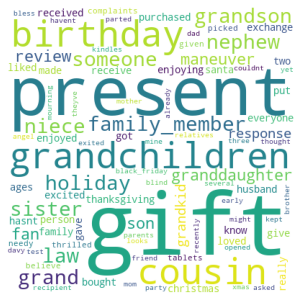

best buy price worth product would looking definitely sale money everything tablets anyone black_friday purchase value low find stores well ever affordable highly online deal thanks priced something apple cant_beat expensive item better fantastic prices need point say buying cost experience products bestbuy market paid quality cheaper samsung buys range compared cheap another happy wanted stock absolutely give buck much difference performed want tag wont usual bang pleased ipad gift thing budget unbelievably reasonable purchased com go_wrong line perfect found staff picked bargain surprised walmart impressed could bought wait pad local suggested deals pay right inexpensive approach finest searching every_penny available comparrison shipping table lot enjoyed plus job store understand dollar think day saw expectations cashier honor discount youngster advertisement kid solid offer go niece age got features anything expected everyone hundred fire one get always satisfied shop truly fluff 

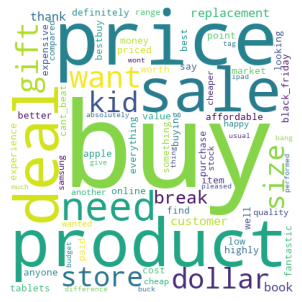

apps like store app google play device download even work doesnt using android cant get access facebook many didnt phone want internet available would could find load works wish lot appstore installed used free without unfamiliar didnt_realize email ads slow much able vudu playstore wifi though isnt useless problem games web cannot made example rely music failed returning rooting allow research snapchat readers wouldnt os need uses things support game otherwise im fare browsing however ipad home anything youtube etc got wanted side_load specific started either gmail really wont run amazons install clans centric instagram sync process possible devices account connect reader reason services know mainly pretty thing fire wasnt loaded fast since major time needs mostly first surfing unless andriod underground hack lack said forgotten read several include antivirus average browser online figuring development money returned add streaming pain prime purchased pages singular affected thats nbc

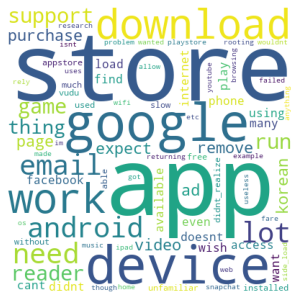

size perfect small right carry purse fits travel big hands enough everywhere smaller compact fit light_weight perfectly bigger need needs around take bag lightweight weight traveling handy anywhere convenient along portable larger carrying hand bulky trips pocket color backpack large purses travelling backpacks light handle carried everything hold space either bring something exactly plane wherever accessibility tuck phone viewing smart pink covers readily heavy transportable bedsides comfortable laptop neat inches momma brief pockets bookbag tge case tobe reasonably sturdy seat go slides families goes amount balances cabinet throw lighting cary privacy briefcases toddlers jobs flashy immensely tend pricepoint beach favorites ser kendle wed lap bulk recent accessible seemless rides practical prompted holds_charge appearance amd area supplement pocketbook letters apron blocked lil somthing batteryseems steals pig lunch goodness peppa hangin arms routine bedtime overalls awake refunding 

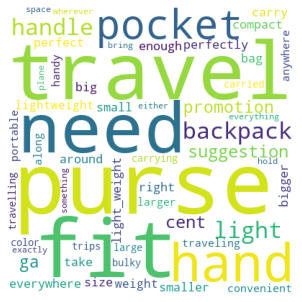

xmas nephews grandsons brought nephew nieces holidays hit grandchildren neice grandparents father grandkids cousins grands fathers_day completed fell birthday customizable harder code ouch wise leap placed talked struggle pin renew continued louder googleplay stated noted unnecessary result hesitated crashed testing mi abc wind housing hence weekends itll join certificate nightly hardware dumb toilet department wondering uncle driven telling marketplace aside section vacuum eat blocked copies created narrow town thomas plain outdoor complaing slipped downloadable possibility switching forgot becasue youve grade mistake mins tomorrow housework recall coloring appears suddenly accomplish reputable lie peaceful frames photo brothers strain passed pushed responsible yo interest covered inserts restricting suffice watche daddy accidental terms un sonce ex afordable imo travelingin onboard cluttered release omg advert tunes granted cords forty fyi hood elsewhere mamma casting justify customi

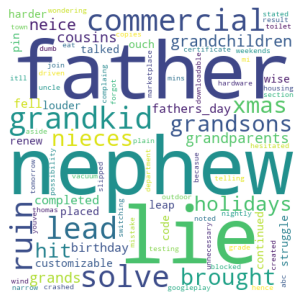

family person gifts family_member family_members received friend enjoyed recipient friends excited everyone loved presents liked gift gave give given present happy employee heard enjoying complaints thank pleased grandparents door made grandsons thoroughly prize nieces thrilled party holidays whole recommended feedback seemed grandkids relatives told siblings popular adopted items item christmas proud holiday hit tutorial babies initial donate tell reviews hope awhile giving idea several nephews thus swap entire introduction grandchildren sisters stated glad parents xmas fell members treat requested prizes camper fourth away aware units ecstatic winner number customers event staff fires seem stick foster regardless youth service benefits asia unhappy attached completed reception chris ose receiver disappoint surprise hesitated angel smile report thrilledwith noted unnecessary pain unsure digi yet extremely secret cover information hood considered impressed flixster grandchild personsll

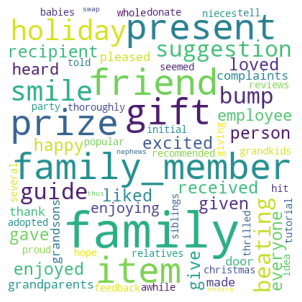

memory card gb phone storage space enough add small sd_card extra size micro_sd needs capacity expand bigger lots travel lot need slot like smaller requires larger camera work among screen photos reader carry large sized put right well features plenty micro hands wi_fi apps via expandable ability cloud bright internal doesnt increase display uploads ofgreat easily usb external wifi pictures smart decent fast hold plus internal_memory fits able yet works purse easier available prime videos want though sharp data go power limited bluetooth graphics convenient lap big resolution audible laptop goodies portable long portfolio pretty somewhat makes little majority connects fit around responsive seems complaint additional disk capability speaker weight save adding music allows run allow expanding however unit expandable_memory direct perfect battery touch compatible compact warned much ipad expansion device real aduquate could beware added take drive mobile plugging something virtually mp st

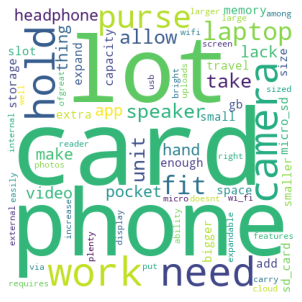

grandson yr son nephew six loves granddaughter old years year absolutely knows yo autistic five seven four nabi daily_basis niece olds bday brother dad surpassed eight yrs pieces itd brought enjoys east daughter thet boy three grandbabie entirely elder shes rubber teenage uncle core foe fo lead refunding grandma hood nine unintended age discussed sixe father credited bought graduation bible leaves matured xmas common steals digi abcs south taught deeply married tabo perfect quilty animal group sixth numbers interaction abc sort mentally someting hence hadnt relationship holey interactive deleting pin moley homepage yous refuses vacuuming hime thirteen silicone chore sanctioned war impression stupid thomas demo happiest asks ghosting parental longevity necessity disabled tempting einsteins noted twisted security chassis megapixels delay serviceable stutter gobbling outperform picks gorgeous underwhelmed valentines occurred society mamma guidance lastly antonio aspergers filters fooled a

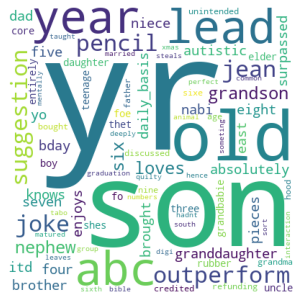

doesnt battery long work wifi charge time wi_fi slow problem ads didnt battery_life keep thing get lasts longer phone without put last hours back sometimes wouldnt cord plug like issues ok properly go hard home always going using charged times hold takes days charging_port cant charger issue connect want charging could works keeps even wont recharge reset wish seems sure ive though working power runs far however stuff hot gets take pad bit man connection havent stays dies pay yet stay months none port operations make restart returning really biggest annoying freezes try turn password goes shutdown busy dislike start changed putting day getting cable maybe way advertisements forever otherwise charges sign tired set tried took ups keeping anyway difficult amount used say never trying fixed need change manually hour quickly us usps duh ended im switch lock often since faster stars still everything isnt sit box started pop loose ride fast length fix little worked gonna lag passcode tonight

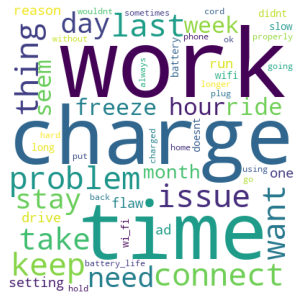

well screen apps tablets get lot quality much pad price value device like better apple fire pretty camera really app little time store parental_controls one overall android still access buy ive memory bought cost free gb son cant even would decent fast os games set low child works could videos ipad prime battery_life best far easy durable perfect cheap kid enough money kids budget features absolutely storage kindle sd_card compared product worth resolution black_friday play need needs size bucks think impressed got old year looking im able everything inexpensive video first say responsive micro_sd want near using makes blurry surprisingly display touch hd daughter new purchase music graphics available card range feels facing children small generation smooth underground pros performance loves download hold isnt slot battery acct bit keep cant_beat protector functions sharp add seems gift sale ecosystem designed especially rear loud speed snappy buying clear expect cons used useful pictu

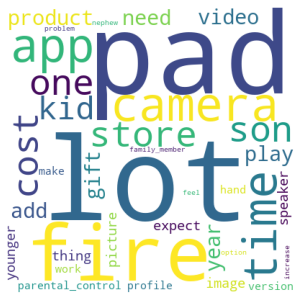

mom mother law sister wife niece likes dad birthday loved brother present tech_savvy gift father shes daughter absolutely enjoys gave whos loves mothers_day husband daughters granddaughter got girlfriend grandma thinks boyfriend brought grandmother mas aunt seems th_birthday hasnt put granddaughters christmas xmas husbands god lives girlfriends savvy grand uses said fathers_day bought hear step sisters sons nephew helps enjoying laws thanks hates moms really hope nieces tech surgery bible stays ill loving coworkers finds amd uncertain liked chemotherapy radiation slowly puts computers ridiculous talking wishes wants thankful jamaica citizen names amzon speaks exception volumes shout touched college ly tha pitch conversations truly designed acess dowloads presents plays princesses techie videis syndrome smail caring friend never overuse complaints lieu sleeps touching written homebound entertained holiday shed elderly skypes illiterate techo ro git arms bedtime rea everyday accurate ple

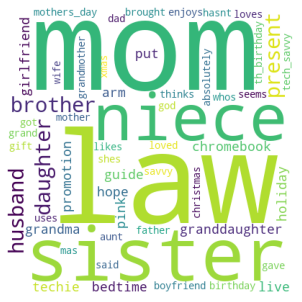

beginner starter beginners proof boys ages adults young customizable children testing create forty completed adult appears student begin complaing parental_control hesitated struggle nightly dads cash wind intending continued telling crashed classroom teenager vacuum pin clearly peaceful weekends omg accommodating sole teenagers blocked rating ouch cast younger placed accomplish code hadnt relationship un result narrow holey renew talked moley abc toilet cluttered town release unnecessary teen slipped onboard section pushed site kudos mi housework hardware entirely join recall eat roku googleplay breaker dumb afordable replaceable pressed mins restaurants musical likely changing mommy worthless convinced itll intuitive seniors louder frames erase thomas ea crush lately definately wrap noted weird hence damages removing walking harder cancel delay aside funds polaroid suffice possibility altogether cry elsewhere outdoor language passed passwords eyesight coloring fault kick lcd nicest u

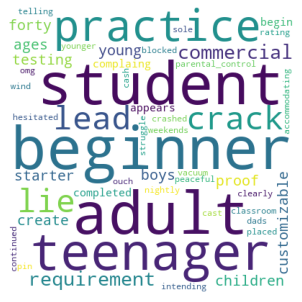

games apps time movies play free download son purchased bought books videos watch kids set old able video year access prime parental_controls purchase perfect netflix app children playing read could buy itunes like tablets christmas little loves music would got store much memory kid wars well internet child get two happy one anything gift props want easy game daughter lot found card uses profile even cant yr commander many fire money black_friday work need product price limits limit watching enough highly parents unlimited available web reading screen using purchases school multiplayer give best control content likes curfew profiles mother etc go minutes case wish mom unrestricted loved underground device downloading following needs google educational gb something size camera knowledge devices kindle overall book grandson downloaded works since adults youtube pad age_appropriate nephew cheap family allowing registered listen quality ages ability fast grandchildren allows everything bec

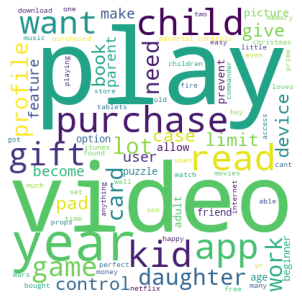

read books want like reading internet email able would facebook wanted fire need well using kindle web one purchase book games reader check really go surf get time got could page im even bought didnt free pc uses surfing sale download lot new play something much everything expensive buy purchased online slow cant apps price disappointed worth mostly first phone accomplish wife emails thought getting etc screen know still another measure print without anything black_friday yahoo losing button happy lugging little mother better way works mail comics pad best playing thats advantage easy instead replace take app power used however else looking husband two device buying money adjust set quick laptop right loves back thing keep product ok ebooks maybe glare christmas far since preloaded gift browsing version watch never notifications couldnt daily twitter rember people paid needs anyone realistic access always expectations pay browse going think sun daughter videos news find pages mom loved

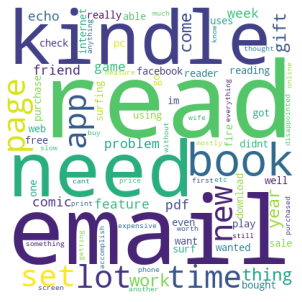

old year durable four yr years eight seven three olds grandson boy age son nephew bought group five case six parental educational parental_controls ten yrs navigate loves kid perfect last easily purchased twelve friendly problems dropped boys knows user_friendly twins put two abc_mouse eleven easy granddaughter pirce shoes autistic works ages alittle ballon niece lol nabi toddler child far learning fifteen suited specs daughter electronic beginner enough especial grandchildren interactive young leftover able compaints abuse chanes almost homework sensory freetime watches operate handle break got streamline cover homeschool twin hose puzzles protection belonging still enjoys plz shes kind strong respectively cross sheuses memorystick utilized brought uses serving nine downloaded pricing broken affortable limites misplaced exact essential held dinosaur gives guidance price takes younger ol mil servicable givinem especiall hardcopy studies haopen parental_control drs sgould tendency bound

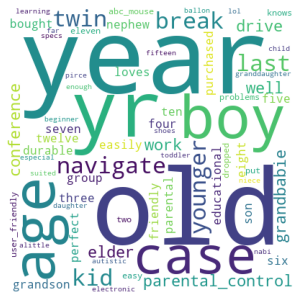

completed design hesitated renew omg customizable struggle noted testing practically telling result ouch code pin talked abc gadget peaceful unnecessary forty placed slipped googleplay switching cluttered afordable eat mi dads harder passwords ea cry travelingin photo consumers restarted blocked entirely polaroid convinced digi reinstall hence louder nightly restricting musical covered downs itll enable wondering becasue accidental land freed matured pushed recall vacuum hood pat unicorn cancel toilet beetle continued advert megapixels lately ghosting dumb un sole reputable thomas tomorrow ose hill sesame sonce akward defender onboard approve intending polite replaceable forgot housework jw respects candle twisted dang daddy chassis accommodating stripped release gripe crispier netfkix kidproof leshooting chargeable mins complaing casting crashed deeply sixth married forfpor salesperson cracks sweeter mommy lesser lastly imo fatherl underwhelmed eyesight commercials wind boops changing

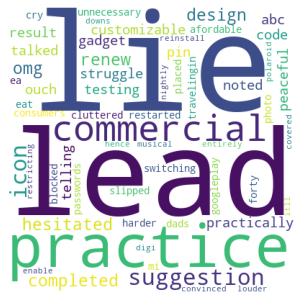

kindle fire much better new screen read like well reader reading hd still one using purchased camera original battery years battery_life replace features books page really bought lighter old sleep im paperwhite easier previous generation faster smaller device first compared used bit keyboard color back upgrade pdfs ive larger pad model older email phone button seems quality plus get small works makes scriptures longer take little two web lot display happy black need things slightly long problems st wife size fast pdf speed format would offers year want perfect work version tab able fires daughter light aloud adequate since night could uses easy bookmark far annotation practically hdx commentaries time annotate resolution pretty micro_sd previously loved issues games serious goodreads bigger interface convert wish cant_beat loves needs price opted mode personal less wi_fi warm many owned paper_white passages ads picture memory times often add different blue_shade gift exactly another da

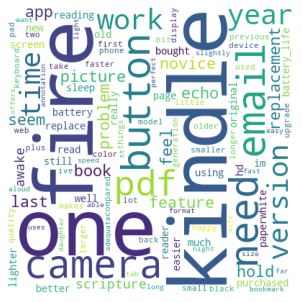

bought one year two christmas old purchased years last since niece son got dad husband yr tablets grandson daughter grand birthday granddaughter still nephew happy wife loved three yrs replace loves case absolutely sister nephews present ago another years_ago wanted put months liked broke shes gift gifts grandkids mom going grandsons ages granddaughters mother first kindle far four broken oldest nieces twin much likes couple cracked ever friends older think strong brought digiland time dropped mine already family easy cousin uses children grandchildren several boys took child even six used opened havent hes second pod younger seven navigate get working youngest new size kindles kids santa set durable fifth lasted died xmas im ive ended buying decided longer using couldnt aug blue fire brand getting ringer sisters ipdad excited law twelve plays never belonging parents playing ppl really young right enjoying complains saund well thank gan especiall play saw price buy came original almost

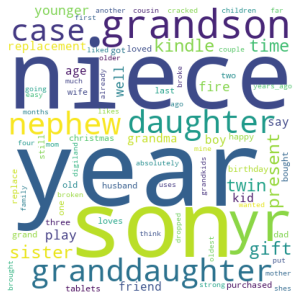

store android apps google app available many wish limited download operating_system sideloaded play apple missing free normal come used services amazons miss market cannot options side_load compatible doesnt open allow arent due tablets googles overall include root thing though without chrome even integrate os hack phase pave ok device products virus lack wouldve emulator otherwise poetically wary lots pre_installed run official underground satisify access vs fan world unavailable system experience uploading drawback different dedicated directly get cant compatibility significant software prime unless disappointed running installing know ability chromecast unable add mebr support accept based compared inability like similar centric utility ios commonly variety specs outclasses user able ponder devices range tech_savvy install adware note channels website sum comforts tiles kiosk youtube works functions con runs wow stables technically instantly opinion verities alot channel shame price

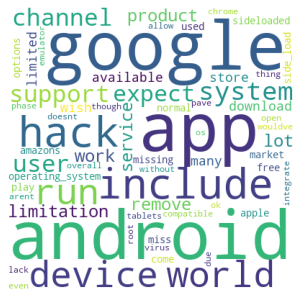

affordable product highly price value reasonable expected priced prices compared cheaper incredible expectations definitely expensive market satisfied brands exceed reasonably_priced products performance range high beat cost sensitivity low service especially quality considering entry_level unbelievable table acceptable point exactly fair folks highly_recommended offers higher top everything suitable anyone passable alternative others unbeatable worth design performs bargain techies vanilla fraction offered pleased every_penny rated beginners functional coworker expect pre durability experienced teen overall functionality teens efficient buyer mediocre totally rich budget greatness proud average high_end premium rivals predecessors item groups prize non reliability pix shoppin looking offcourse companies exelent manufacturers unmatched toward pre_loaded quarte end harmony maximum beginner happier icon combine line proves minimum phenomenal exceeds convert least entry capable brings ret

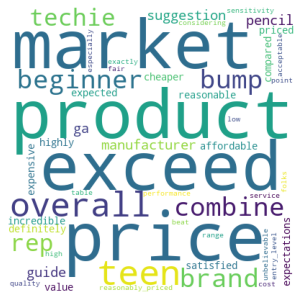

watching netflix tv shows movies surfing hulu watch movie browsing airplane youtube web novels reading emails streaming listening checking surfs streams music hbo bed gaming television household sea prime kitchen playing internet diy surf offline traveling notes player mainly recorded listen video recipes addition couch sitting road_trips pandora room videos kool browse watches hdmi ebooks search moderate checking_email tvs hubby hi binge images sound hoopla house mkv humans mp mx loads hotel watched retreats favorite appointment student quilt plane sealed waiting output area magazines newspaper shopping gre picture sceen snows net van filter res casual go anywere reclaimed sonos tends outdated infinity pokemon tasks hook reservations searching thats seats view daugther silk crystal_clear travelling freeze guest office tube remote aps companion disappointment stations mickey gps scores college catch home summary suits websurfing lets ding plsy tiny rooms wat spotify meets whilst relaxi

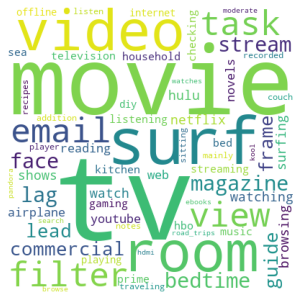

games movies watch videos playing play music watching video tube plays cartoons shows kids learning stream car kid homework youtube streaming movie download prime watches road_trips netflix grandchildren able educational complaints pictures grandkids game tv skips pauses gaming chat win grand letting girls child listen beginning pennybought angst talk downloaded hours task busy listening usable young break uploaded expandable_memory travellers performer teens havent roadtrips libary travel children perfect school younger browse table wi_fi family companion alternative adults alternatives mostly assured expand picture player net etc mile bunch tme long teenagers recommendable keep got introductory media_consumption teenage prob babysitter wanting death social_media cards trips parental_controls expands dissapointed slot fun sd_card racing spent kinds surf stored plane driving clips stay road_trip worrying entertain hubby without camara bought stations availability boos endless keeps sal

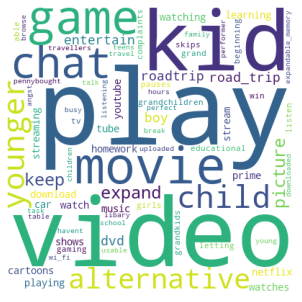

daughter loves uses everyday enjoys mom absolutely wife law likes dad mother keeps daily niece shes granddaughter helps daughters grandma son father mothers_day sister lives grandmother track plays entertained grand school tech_savvy savvy wants college birthday daily_basis husband brother youngest reads bible got perfectly husbands elderly stays lady ama zon teacher parent yo particularly citizen hear assignments sons writing smartphone thinks tail technical impaired boufgt fir alien busy surgery david american finds char bought homework disability resetting improve wed naught form godmother whos uncle works avid kendal hair exception knows portal classroom girlfriend princesses videis move setting street tact costing leaves spends senior nurse minimize ly uncertain overuse pink th_birthday lieu schedule coordination git acess dowloads workes th puts therapy hearing kidzobe leaving amzon shout loving mas pry core steals addl obtain forcing hates wishes church renewal lime pitch conver

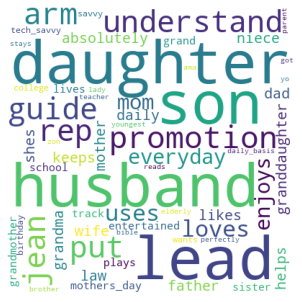

In [96]:
topics = ctm_50_reduce.get_topic_lists(700)
for topic in topics:
  get_wordcloud(topic)

## Changing n_components: (n_components = n_topics)

In [19]:
training_dataset = CTMDataset(handler.bow, training_bert, handler.idx2token)
ctm_8 = CTM(input_size=len(handler.vocab), bert_input_size=768, inference_type="combined", n_components=8)
ctm_8.fit(training_dataset)

Settings: 
                   N Components: 8
                   Topic Prior Mean: 0.0
                   Topic Prior Variance: 0.875
                   Model Type: prodLDA
                   Hidden Sizes: (100, 100)
                   Activation: softplus
                   Dropout: 0.2
                   Learn Priors: True
                   Learning Rate: 0.002
                   Momentum: 0.99
                   Reduce On Plateau: False
                   Save Dir: None
Epoch: [1/100]	Samples: [10955/1095500]	Train Loss: 103.42046155281015	Time: 0:00:31.238382
Epoch: [2/100]	Samples: [21910/1095500]	Train Loss: 99.41707265584886	Time: 0:00:30.458393
Epoch: [3/100]	Samples: [32865/1095500]	Train Loss: 98.18596077748816	Time: 0:00:30.215739
Epoch: [4/100]	Samples: [43820/1095500]	Train Loss: 97.69339226879849	Time: 0:00:30.378597
Epoch: [5/100]	Samples: [54775/1095500]	Train Loss: 97.24173654741699	Time: 0:00:30.577800
Epoch: [6/100]	Samples: [65730/1095500]	Train Loss: 97.1995055010

In [20]:
ctm_8.save('/content/')

In [22]:
td = TopicDiversity(ctm_8.get_topic_lists(25))
td.score(topk=25)

0.87

In [23]:
ctm_8.get_topic_lists(10)

[['android',
  'google',
  'cant',
  'store',
  'better',
  'little',
  'money',
  'cheap',
  'apps',
  'pad'],
 ['fire',
  'apps',
  'kindle',
  'screen',
  'books',
  'like',
  'would',
  'read',
  'well',
  'app'],
 ['games',
  'watch',
  'books',
  'reading',
  'playing',
  'movies',
  'watching',
  'web',
  'play',
  'videos'],
 ['exactly',
  'satisfied',
  'expected',
  'service',
  'unbeatable',
  'felt',
  'steal',
  'offered',
  'exceed',
  'perform'],
 ['one',
  'bought',
  'year',
  'old',
  'kindle',
  'purchased',
  'buy',
  'best',
  'fire',
  'christmas'],
 ['beginners',
  'adults',
  'profiles',
  'parental_control',
  'adult',
  'starter',
  'everyone',
  'proof',
  'young',
  'beginner'],
 ['light_weight',
  'easy',
  'compact',
  'lightweight',
  'size',
  'fits',
  'setup',
  'carry',
  'portable',
  'clear'],
 ['birthday',
  'present',
  'loved',
  'granddaughter',
  'nephew',
  'grandson',
  'loves',
  'niece',
  'xmas',
  'brother']]

In [32]:
word2vec_path = '/content/reviews_word2vec.bin'
we_coh = CoherenceWordEmbeddings1(word2vec_path=word2vec_path, topics=ctm_8.get_topic_lists(10))
we_coh.score(topk=10)

0.9150442

In [ ]:
# Get best weights
best_components_8 = ctm_8.best_components 

In [43]:
topic_lists(25, best_components_8)

([['android',
   'google',
   'cant',
   'store',
   'better',
   'little',
   'money',
   'cheap',
   'apps',
   'pad',
   'doesnt',
   'ads',
   'get',
   'price',
   'pay',
   'slow',
   'worth',
   'works',
   'low',
   'lot',
   'like',
   'much',
   'need',
   'even',
   'really'],
  ['fire',
   'apps',
   'kindle',
   'screen',
   'books',
   'like',
   'would',
   'read',
   'well',
   'app',
   'time',
   'get',
   'free',
   'store',
   'reading',
   'much',
   'one',
   'games',
   'play',
   'device',
   'movies',
   'want',
   'tablets',
   'even',
   'download'],
  ['games',
   'watch',
   'books',
   'reading',
   'playing',
   'movies',
   'watching',
   'web',
   'play',
   'videos',
   'internet',
   'read',
   'surfing',
   'music',
   'download',
   'netflix',
   'facebook',
   'surf',
   'able',
   'email',
   'online',
   'tv',
   'book',
   'plays',
   'listening'],
  ['exactly',
   'satisfied',
   'expected',
   'service',
   'unbeatable',
   'felt',
   'steal',

android google cant store better little money cheap apps pad doesnt ads get price pay slow worth works low lot like much need even really memory screen would want overall decent isnt ok expensive quality everything tablets expect less pretty paid wont battery_life didnt app cant_beat resolution bucks display still black_friday limited well okay point fine though go_wrong looking complain something cost ipad youre card compared camera performance however without deal lock could arent bit apple spend fast battery annoying ad youll break say wish value work anything sale high_end full paying things ive add market budget look runs priced device definitely available bargain bank thing fantastic many operating_system products dollar wouldnt stuff disable speed disappointed average rid gb extra seems cannot samsung nothing thats biggest find functionality far range yes inexpensive stars responsive poor root hd smooth mini knock waste buck storage tab regular big although slower top run table 

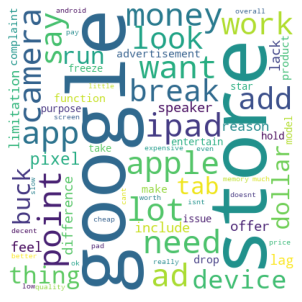

fire apps kindle screen books like would read well app time get free store reading much one games play device movies want tablets even download little quality purchased set able really need using web buy price watch videos could android lot internet access im bought many small better google music prime take enough video new email kids phone go storage perfect work purchase got still easy memory pad reader card value first everything around resolution size features children something child battery_life uses hd works find old gb cant light available ive used since book parental_controls best things needs wifi doesnt home etc product camera looking wanted fast netflix easily pretty makes battery add overall right kid cost micro_sd make bluetooth way without os page didnt decent watching easier two sound highly account carry getting amazons happy purchases version slow year sale cheap browsing facebook streaming thing compared browser expect display far bigger fine content bit load however

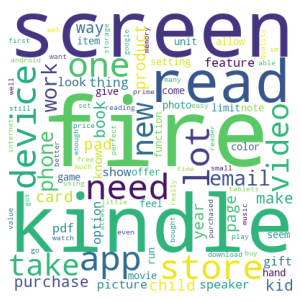

games watch books reading playing movies watching web play videos internet read surfing music download netflix facebook surf able email online tv book plays listening perfect downloading browsing check emails browse learning shows listen etc game uses watches mails checking net homework likes mostly magazines ebooks go checking_email stream news video social_media prime streaming tube enjoys meets hulu youtube library travel car occasionally son downloaded educational movie public school local_library works gaming mainly traveling favorite lots chat search reads access articles enjoying various anywhere fun road_trips free entertainment catch companion surfs browses emailing needs busy loves shopping pass purse social pictures allows downloads audio activity searching mail alot letting occasional trick bunch vacation face monitor shop grandfather player gets anything digital take done discover car_rides without helps lets bills law house college storing entertainer complaints wanted eu

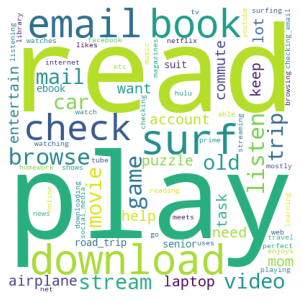

exactly satisfied expected service unbeatable felt steal offered exceed perform walking vehicle periodically hrs scriptures lockscreen prices positioned asks unexpected chargeable expectations brands insert fault deep buck ask belonging mic bargain performs beat indicated waited weve sending backlit market allowed promptly lake apartment accomplish comfort escalated telling affordable restaurants leshooting staying troub becuz exact product evaluating attempt toilet defected sits flix dinner bang miles happen job_done hyped accesses cancel traded click priced lo appears asking rating cash code coloring doomed correct storming bullet pressed latest reasonable story vidios logging contract slipped casually inside funds remaing nearby hill trash refurbished deciding bumps highly_recommended accepted bells troubleshooting exclusively conventional teenaged outs whistles pinch el thirty totally seeking switching pointing decreased continued sole nagging settling thomas shoot meaningful becas

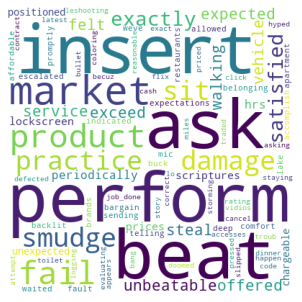

one bought year old kindle purchased buy best fire christmas two happy new years first got time another charge last since replace would tablets son purchase wife much get yr gift second black_friday grand kindles daughter months longer still back broke gifts three ive warranty older decided family four set years_ago replacement told children long really child day never several kids gave us husband loved case charging mother grandkids working product going mom im couldnt didnt ordered kid worked lasted grandchildren stopped even went ever started fires better original help liked navigate newer wanted charger absolutely pleased ages excited month said week exchanged ago weeks used dropped received opened sale purchasing cheaper buying santa within item friend replaced could hes using cracked stopped_working kept enjoyed version later issues defective keep grown return friends put sons broken granddaughter well far deal took battery mine charged problem thanks durable tried asked died cam

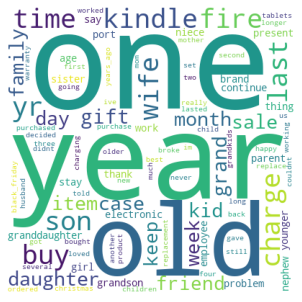

beginners adults profiles parental_control adult starter everyone proof young beginner suggest fault controls scriptures younger periodically insert format students lockscreen sending vehicle positioned happen indicated breaking walking hrs tables users boys entertainment unexpected mode programs chargeable deep belonging losing asks olds toddler interested mic accomplish dinner promptly hyped family_members inside allowed frustrated bundle correct lake staying click tool whole comfort cash manage defected becuz deciding toilet childs hill accesses separate angles rd freed sits restaurants apartment attempt dedicated exact logging em coloring story bullet ages flix educational customizable lo abuse evaluating contract escalated backlit rating bumps vidios decreased traded leshooting exclusively funds telling remaing shoot troub teenaged thomas switching becasue individual types tomorrow hour pointing comments slipped precious miles allowing create worry outs accepted monitor pressed tr

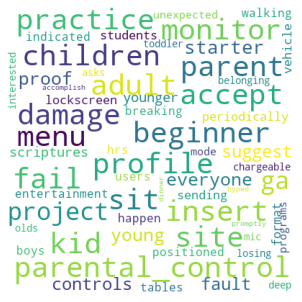

light_weight easy compact lightweight size fits setup carry portable clear convenient purse color quick travel pictures navigate fast small pocket picture bright light weight operate handle right space larger lasts bag anywhere smaller understand traveling bigger colors easier handy power lighting ease plane large eyes bulky hands slot upgrade connects holds_charge cable info fit interface battery easily capacity response vibrant graphics enough wireless carrying expandable keyboard expandable_memory camera responsive usb recharge expanded standard photos trips increase load pics vid additional takes big clarity playthings scriptures display smart comfortable confined periodically fills hold loads laptop battery_life indicated lake perfect expansion convenience amount wonderful durable shipping chargeable st instructions count travels respond perfectly hrs taken mic port set doable unexpected operating long features covers positioned along attempt quickly playground benefit pod refurbi

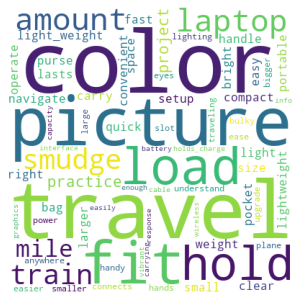

birthday present loved granddaughter nephew grandson loves niece xmas brother daughter law sister mom gift dad brought absolutely nieces father shes nephews mothers_day hasnt enjoys christmas gifts presents mother gave grandma holidays son enjoying everyday excited yr daughters grand enjoyed granddaughters tech_savvy recipient th_birthday yrs received girlfriend scriptures sons husband plays favorite elderly grandsons wife recently periodically walking played hes lake hrs holiday mic puts bible accesses asks lockscreen enables unexpected hyped evaluating positioned indicated chargeable exclusively becuz friend defected grandmother got refurbished vehicle complaints comfort hit el liked attempt thinks belonging promptly truly annotation cancel traded sensory six drinking contract bullet buddy becasue teenaged commentaries bookmark bought outs shoot fell thomas accepted bedtime coloring accomplish boyfriend deep youngest pointing vidios family_member smudged sits escalated coating rig ma

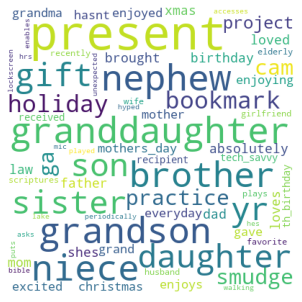

In [67]:
topics = ctm_8.get_topic_lists(700)
for topic in topics:
  get_wordcloud(topic)